# Preprocessing: ECB EUR/CZK Exchange Rate (Monthly)
This notebook processes EUR/CZK exchange rate data from the European Central Bank (ECB).
**Source:** ECB CSV (ecb_eurczk_monthly_raw.csv)
**Target:** Monthly frequency, `timestamp` index, `eur_czk` column.

**Steps:**
1. Load raw data.
2. Transform to time series format.
3. Data cleaning (Null check, Data types).
4. Set Index and Frequency.
5. Save processed dataset.
6. Visualization check.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set plot style
plt.style.use('seaborn-v0_8')

# Define file paths (relative to this notebook in preprocessing/ folder)
input_file = '../datasets/ecb_eurczk_monthly_raw.csv'
output_file = '../datasets/ecb_eurczk_monthly.csv'

# Ensure output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

In [9]:
# 1. Load Data
# Read the CSV file
try:
    # ECB data often uses semicolon separator
    df_raw = pd.read_csv(input_file, sep=';') 
    print("Raw data loaded successfully.")
    print(df_raw.head())
except Exception as e:
    print(f"Error loading data: {e}")

Raw data loaded successfully.
       Period      *   Unnamed: 2
0  2025-11-30   24,17         NaN
1  2025-10-31  24,335         NaN
2  2025-09-30   24,34         NaN
3  2025-08-31  24,445         NaN
4  2025-07-31   24,57         NaN


In [10]:
# 2. Transform to Time Series Format
# Inspect columns to identify timestamp and value columns
print("Columns:", df_raw.columns)

# Rename columns for consistency
# We will select the relevant columns.
date_col = df_raw.columns[0] # Usually the first column ('Period')

# Try to find rate column by name or position
rate_col_candidates = [col for col in df_raw.columns if 'CZK' in col or 'Value' in col or '*' in col]
if rate_col_candidates:
    rate_col = rate_col_candidates[0]
else:
    # Fallback to 2nd column if specific names not found
    rate_col = df_raw.columns[1]

print(f"Selected Date Column: {date_col}")
print(f"Selected Rate Column: {rate_col}")

df = df_raw[[date_col, rate_col]].copy()
df.columns = ['timestamp', 'eur_czk']

print("\nFirst 5 rows after transformation:")
print(df.head())

Columns: Index(['Period', ' * ', 'Unnamed: 2'], dtype='object')
Selected Date Column: Period
Selected Rate Column:  * 

First 5 rows after transformation:
    timestamp eur_czk
0  2025-11-30   24,17
1  2025-10-31  24,335
2  2025-09-30   24,34
3  2025-08-31  24,445
4  2025-07-31   24,57


In [11]:
# 3. Data Cleaning & Type Conversion

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['timestamp'], inplace=True)

# Convert exchange rate to float
# ECB data often uses ',' as decimal separator. We need to replace it with '.'
if df['eur_czk'].dtype == 'object':
    df['eur_czk'] = df['eur_czk'].str.replace(',', '.', regex=False)

df['eur_czk'] = pd.to_numeric(df['eur_czk'], errors='coerce')

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values
if df['eur_czk'].isnull().sum() > 0:
    print("Dropping rows with missing exchange rate values.")
    df.dropna(subset=['eur_czk'], inplace=True)

# Verify Data Types
print("\nData Types:")
print(df.dtypes)


Missing Values:
timestamp    0
eur_czk      0
dtype: int64

Data Types:
timestamp    datetime64[ns]
eur_czk             float64
dtype: object


In [12]:
# 4. Set Index and Frequency

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Sort index to ensure chronological order
df.sort_index(inplace=True)

# Set frequency to Month Start (MS) or Month End (M) depending on data
# Let's infer frequency or force it.
# ECB monthly data is usually average or end of period.
# Let's check the day of the month to decide between MS (Month Start) or M (Month End)
day_counts = df.index.day.value_counts()
print("\nDay of month distribution:")
print(day_counts)

# If mostly 1st of month, use MS. If variable, we might need to resample or snap to nearest.
# Let's try to set frequency to Month Start (MS)
try:
    # If dates are not start of month, snap them to start of month for consistency
    # This is a design choice for monthly data.
    df.index = df.index + pd.offsets.MonthBegin(0)
    df = df.asfreq('MS')
    print("\nFrequency set to 'MS' (Month Start).")
except Exception as e:
    print(f"\nCould not set frequency: {e}")

# Verify Index
print("\nDataFrame Index Info:")
print(df.index)

# Check for gaps
if df.index.freq == 'MS':
    print("Time series is continuous with Monthly Start frequency.")
else:
    print("Warning: Time series frequency could not be strictly enforced.")


Day of month distribution:
timestamp
31    224
30    129
28     24
29      8
Name: count, dtype: int64

Frequency set to 'MS' (Month Start).

DataFrame Index Info:
DatetimeIndex(['1993-12-01', '1994-01-01', '1994-02-01', '1994-03-01',
               '1994-04-01', '1994-05-01', '1994-06-01', '1994-07-01',
               '1994-08-01', '1994-09-01',
               ...
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
               '2025-11-01', '2025-12-01'],
              dtype='datetime64[ns]', name='timestamp', length=385, freq='MS')
Time series is continuous with Monthly Start frequency.


In [13]:
# 5. Save Processed Data
df.to_csv(output_file)
print(f"Processed data saved to: {output_file}")

Processed data saved to: ../datasets/ecb_eurczk_monthly.csv


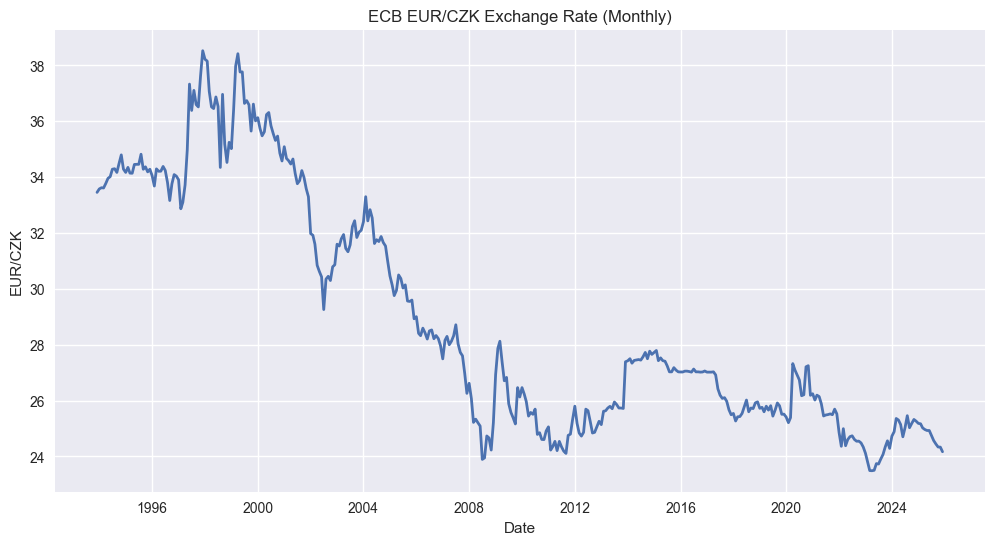

In [14]:
# 6. Visualization Check
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['eur_czk'], linestyle='-', linewidth=2)
plt.title('ECB EUR/CZK Exchange Rate (Monthly)')
plt.xlabel('Date')
plt.ylabel('EUR/CZK')
plt.grid(True)

plt.show()